In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import StratifiedKFold

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

import zipfile
with zipfile.ZipFile('/kaggle/input/platesv2/plates.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('/kaggle/working/')
    
print('After zip extraction:')
print(os.listdir("/kaggle/working/"))

data_root = '/kaggle/working/plates/'
print(os.listdir(data_root))

import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'
overall_dir = '/kaggle/working/overall_dataset'
class_names = ['cleaned', 'dirty']



os.makedirs(overall_dir, exist_ok=True)
#for class_name in class_names:
#    os.makedirs(os.path.join(overall_dir, class_name), exist_ok=True)
image_num = 0
    
list_of_dirs = ['/kaggle/working/overall_dataset/cleaned','/kaggle/working/overall_dataset/dirty']
list_of_plates = []
for class_name in class_names:   
    for file in os.listdir(data_root+'train/'+class_name):
        file_name = os.fsdecode(file)
        if (file.endswith(".jpg")):  
            shutil.copy(os.path.join(data_root+'train/'+class_name, file_name), 
                        os.path.join(overall_dir, class_name + ' ' + str(image_num) + '.jpg'))
            list_of_plates.append(class_name + ' ' + str(image_num) + '.jpg')
            image_num = image_num + 1

import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy
import random
from PIL import Image


from torchvision import transforms, models
from torchvision.transforms import functional
from torch.utils.data import ConcatDataset
from matplotlib.animation import FuncAnimation
batch_size = 8


#for each_dir in list_of_dirs:

            
list_of_classes = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]

def set_random_seed(random_seed):
    torch.manual_seed(random_seed)
    random.seed(random_seed)
    np.random.seed(random_seed)
    
set_random_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

['platesv2']
After zip extraction:
['__MACOSX', 'plates', '.virtual_documents']
['train', '.DS_Store', 'test']


In [3]:
strat_kfold = StratifiedKFold(n_splits=5, shuffle=True)

for fold, (train_ids, test_ids) in enumerate(strat_kfold.split(list_of_plates,list_of_classes)):
    
    fold_dir = '/kaggle/working/'+'fold ' + str(fold)
    os.makedirs(fold_dir, exist_ok=True)
    os.makedirs(fold_dir+'/train', exist_ok=True)
    os.makedirs(fold_dir+'/train/cleaned', exist_ok=True)
    os.makedirs(fold_dir+'/train/dirty', exist_ok=True)
    os.makedirs(fold_dir+'/val', exist_ok=True)
    os.makedirs(fold_dir+'/val/cleaned', exist_ok=True)
    os.makedirs(fold_dir+'/val/dirty', exist_ok=True)
    
    for each_elem in train_ids:
        
        if (each_elem < 20):
            shutil.copy(os.path.join(overall_dir, list_of_plates[each_elem]), 
                            os.path.join(fold_dir+'/train/cleaned', list_of_plates[each_elem]))
        else:          
            shutil.copy(os.path.join(overall_dir, list_of_plates[each_elem]), 
                os.path.join(fold_dir+'/train/dirty', list_of_plates[each_elem]))
                        
    for each_elem in test_ids:
        
        if each_elem < 20:
            shutil.copy(os.path.join(overall_dir, list_of_plates[each_elem]), 
                            os.path.join(fold_dir+'/val/cleaned', list_of_plates[each_elem]))
        else:          
            shutil.copy(os.path.join(overall_dir, list_of_plates[each_elem]), 
                os.path.join(fold_dir+'/val/dirty', list_of_plates[each_elem]))

In [4]:
def prepare_data_set(train_dir,val_dir,batch_size, num_of_augmentaions = 10):
    
    list_of_train_datasets = []        
    
    for i in range(num_of_augmentaions):
        
        train_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])    
            
        train_dataset = torchvision.datasets.ImageFolder(train_dir,train_transforms)   
        
        list_of_train_datasets.append(train_dataset)
            
    train_dataset = ConcatDataset(list_of_train_datasets)
    
    val_transforms1 = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms1)
    
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
    val_dataloader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)
    
    return train_dataloader, val_dataloader

def show_transformed_image (transrorm, img):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    pic_tensor = transrorm(img)
    pic_array = pic_tensor.permute(1, 2, 0).numpy()* std + mean
    
    rows = 2
    columns = 2
    fig = plt.figure(figsize=(10, 7)) 
    fig.add_subplot(rows, columns, 1) 

    # showing image 
    plt.imshow(img) 
    plt.axis('off') 
    plt.title("Before") 

    # Adds a subplot at the 2nd position 
    fig.add_subplot(rows, columns, 2) 

    # showing image 
    plt.imshow(pic_array) 
    plt.axis('off') 
    plt.title("After") 
        
def show_input(input_tensor, title=''):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)


In [5]:
def train_model(device,fold_num,model, loss,optimizer, 
                scheduler,accuracy_history_train,accuracy_history_val,
                epoch_history,train_dataloader,val_dataloader,best_model, num_epochs):    
    best_val_acc = 0
    best_train_acc = 0
    for epoch in tqdm(range(num_epochs)):
        
        epoch_history.append(epoch)
        #print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                #print(preds_class)
                #print(labels.data)
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            if phase == 'train':
                accuracy_history_train.append(epoch_acc.item())
            else:
                if epoch_acc.item() >= best_val_acc:
                    #print('best model - ' + str(epoch_acc.item()) + ' val accuracy')
                    torch.save(model.state_dict(),'/kaggle/working/best_modelx_fold_'+ str(fold_num) +'.pt')
                    best_val_acc = epoch_acc.item() 
                
                    #print(model.state_dict())
                    #best_model = model.state_dict()
                accuracy_history_val.append(epoch_acc.item())

            #print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [6]:
#model = torch.hub.load('ultralytics/yolox8', 'yolo8x') 
def perform_training_instance(fold_num,batch_size,train_dir,val_dir):
    model = models.resnet18(pretrained=True)

    # Disable grad for all conv layers
    for param in model.parameters():
        #if isinstance(param, torch.nn.Conv2d):
            param.requires_grad = False

    model.fc = torch.nn.Linear(model.fc.in_features, 2)

    
    model = model.to(device)

    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

    # Decay LR by a factor of 0.1 every 7 epochs

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    
    train_dataloader,val_dataloader = prepare_data_set(train_dir,
                                                       val_dir,batch_size)

    epoch_history = []
    accuracy_history_train = []
    accuracy_history_val = []
    best_model = 0
    train_model(device,
                fold_num,model,
                loss, 
                optimizer, 
                scheduler, 
                accuracy_history_train,
                accuracy_history_val,
                epoch_history,
                train_dataloader,
                val_dataloader,
                best_model,
                num_epochs=60)

    print(max(accuracy_history_train))
    print(max(accuracy_history_val))
    plt.figure(figsize=(20,12))
    plt.plot(epoch_history ,accuracy_history_train,label = 'train')
    plt.plot(epoch_history ,accuracy_history_val,label = 'val')
    plt.legend()
    plt.show()


100%|██████████| 60/60 [01:18<00:00,  1.30s/it]


0.9937500357627869
0.875


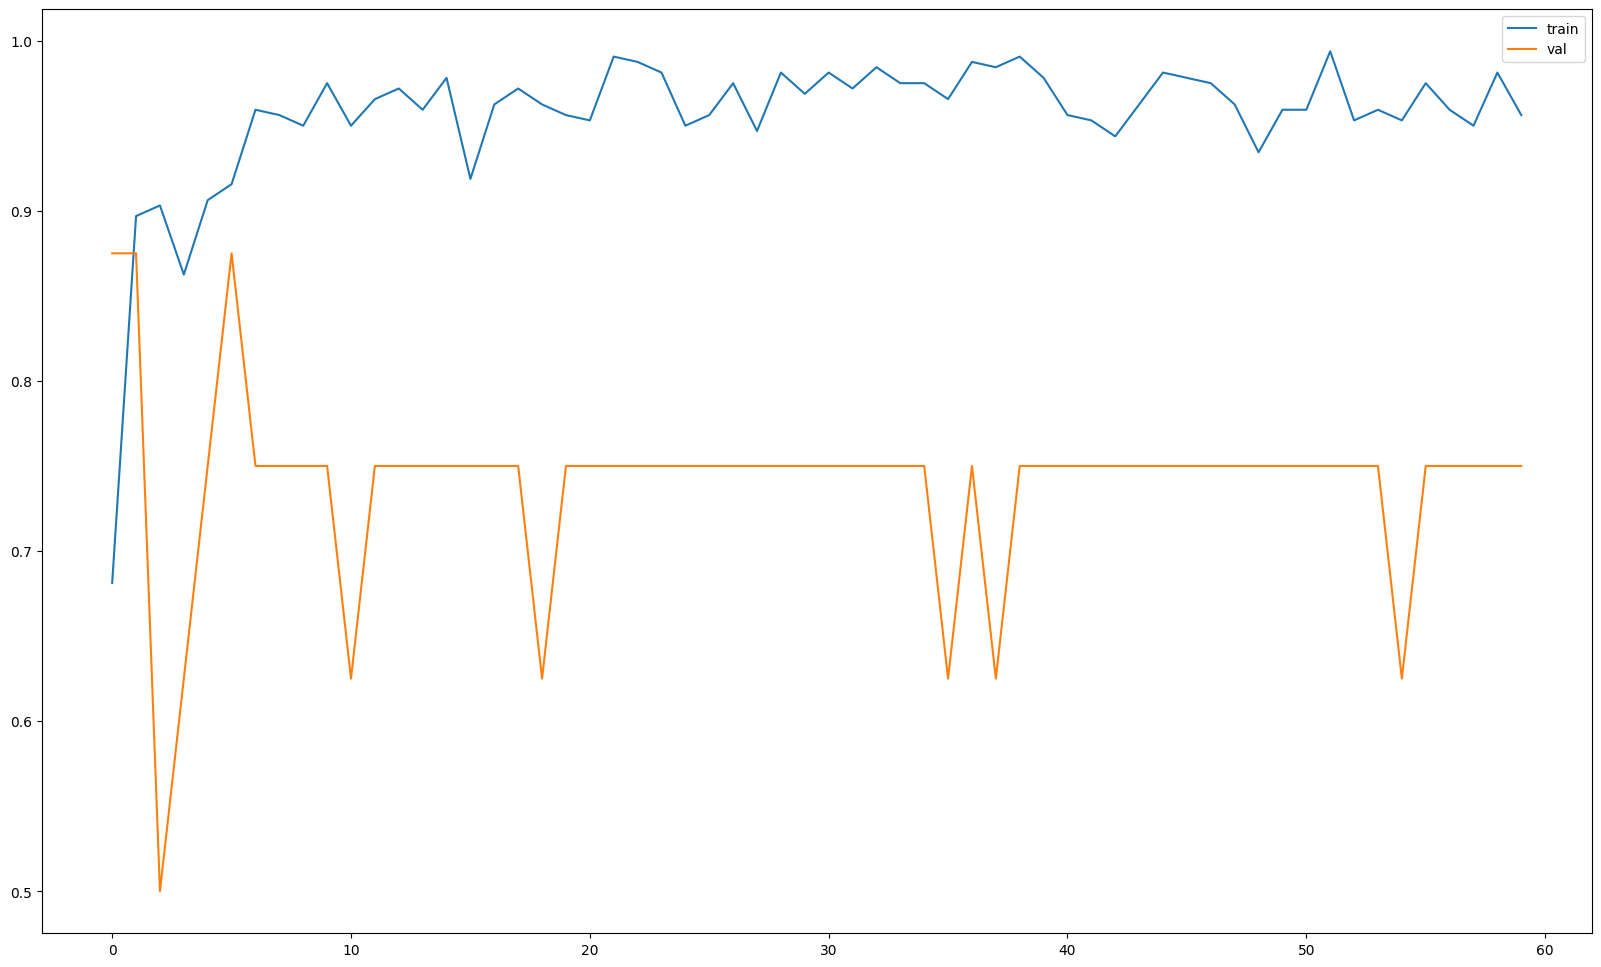

100%|██████████| 60/60 [01:24<00:00,  1.41s/it]


0.987500011920929
1.0


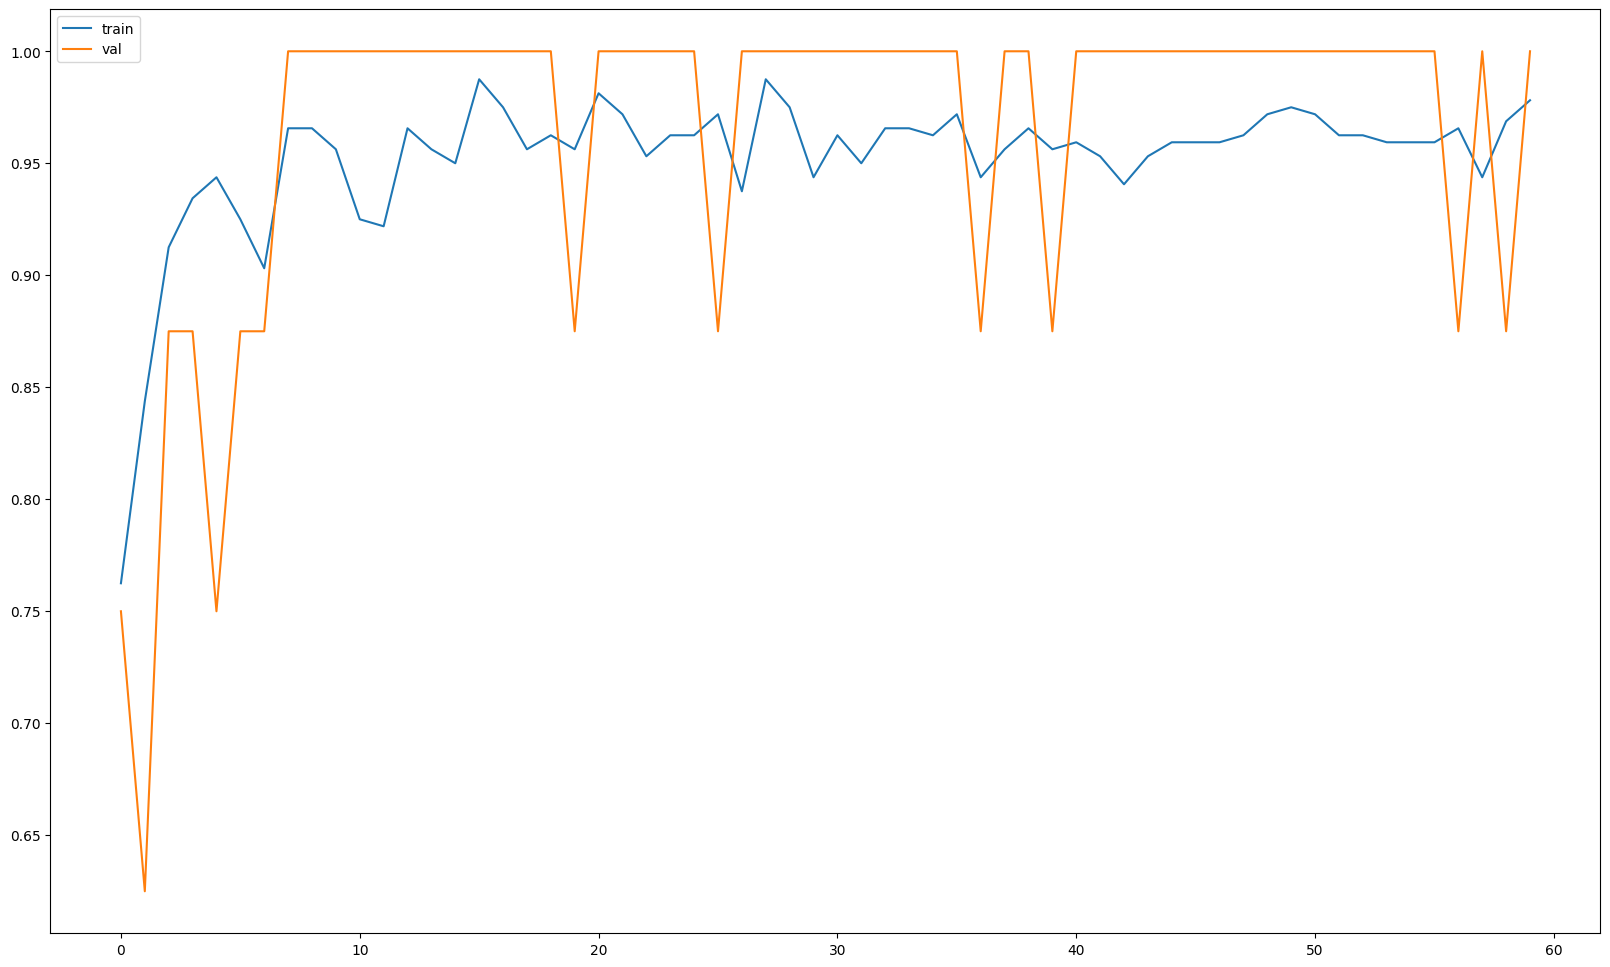

100%|██████████| 60/60 [01:19<00:00,  1.33s/it]


0.984375
0.875


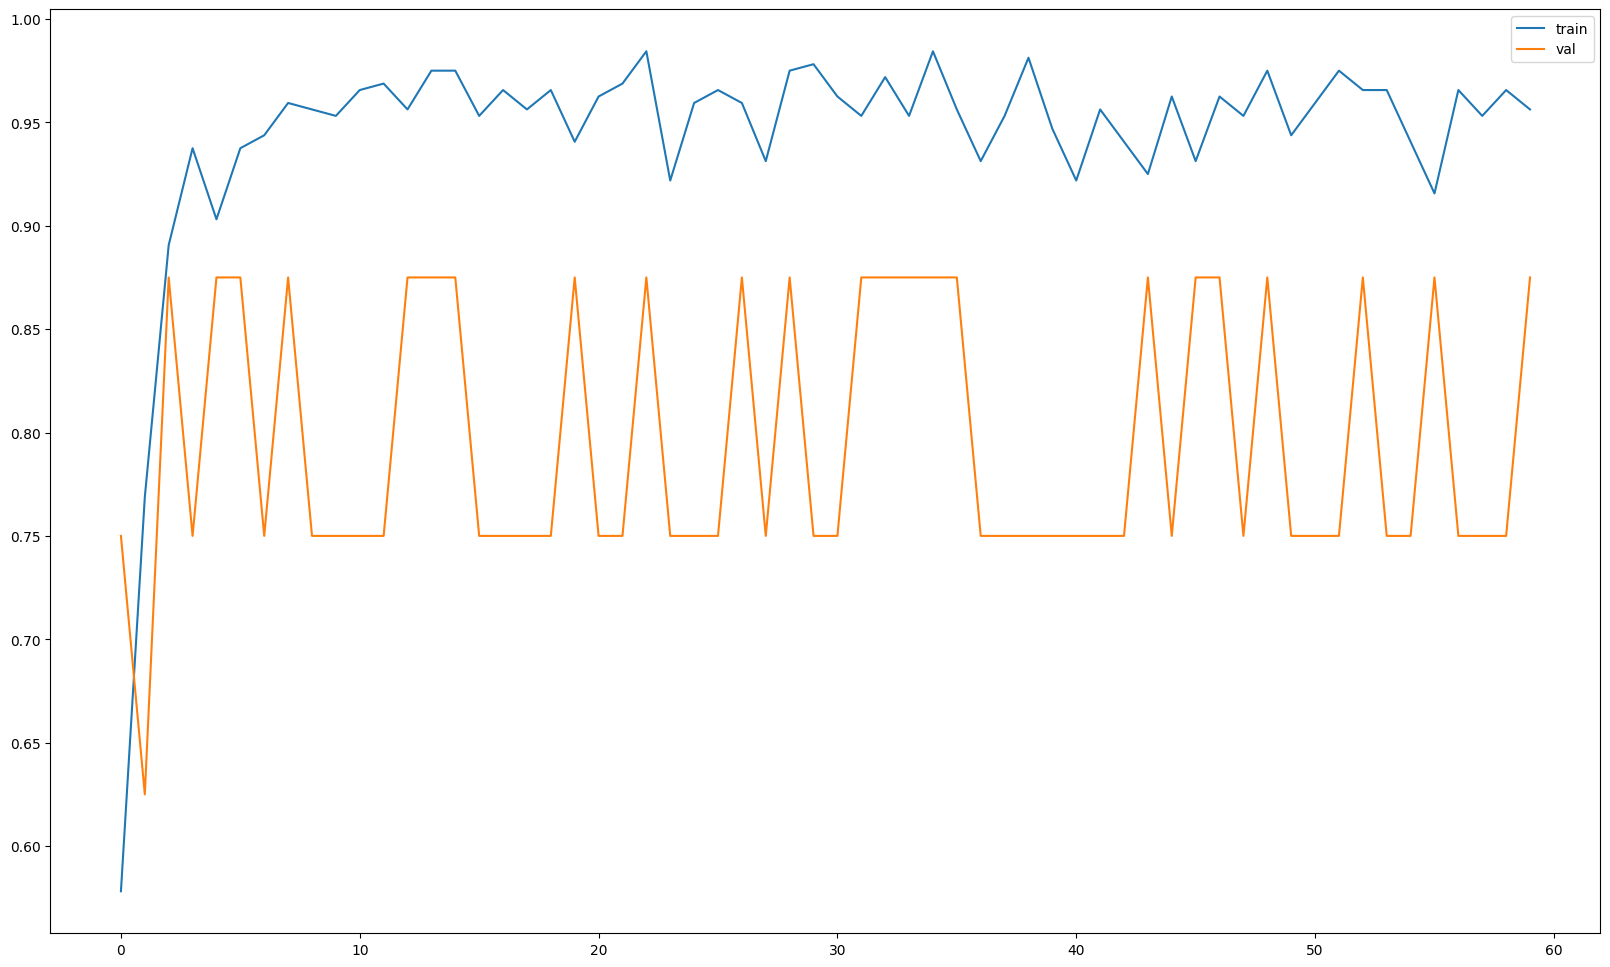

100%|██████████| 60/60 [01:26<00:00,  1.44s/it]


0.9906250238418579
0.875


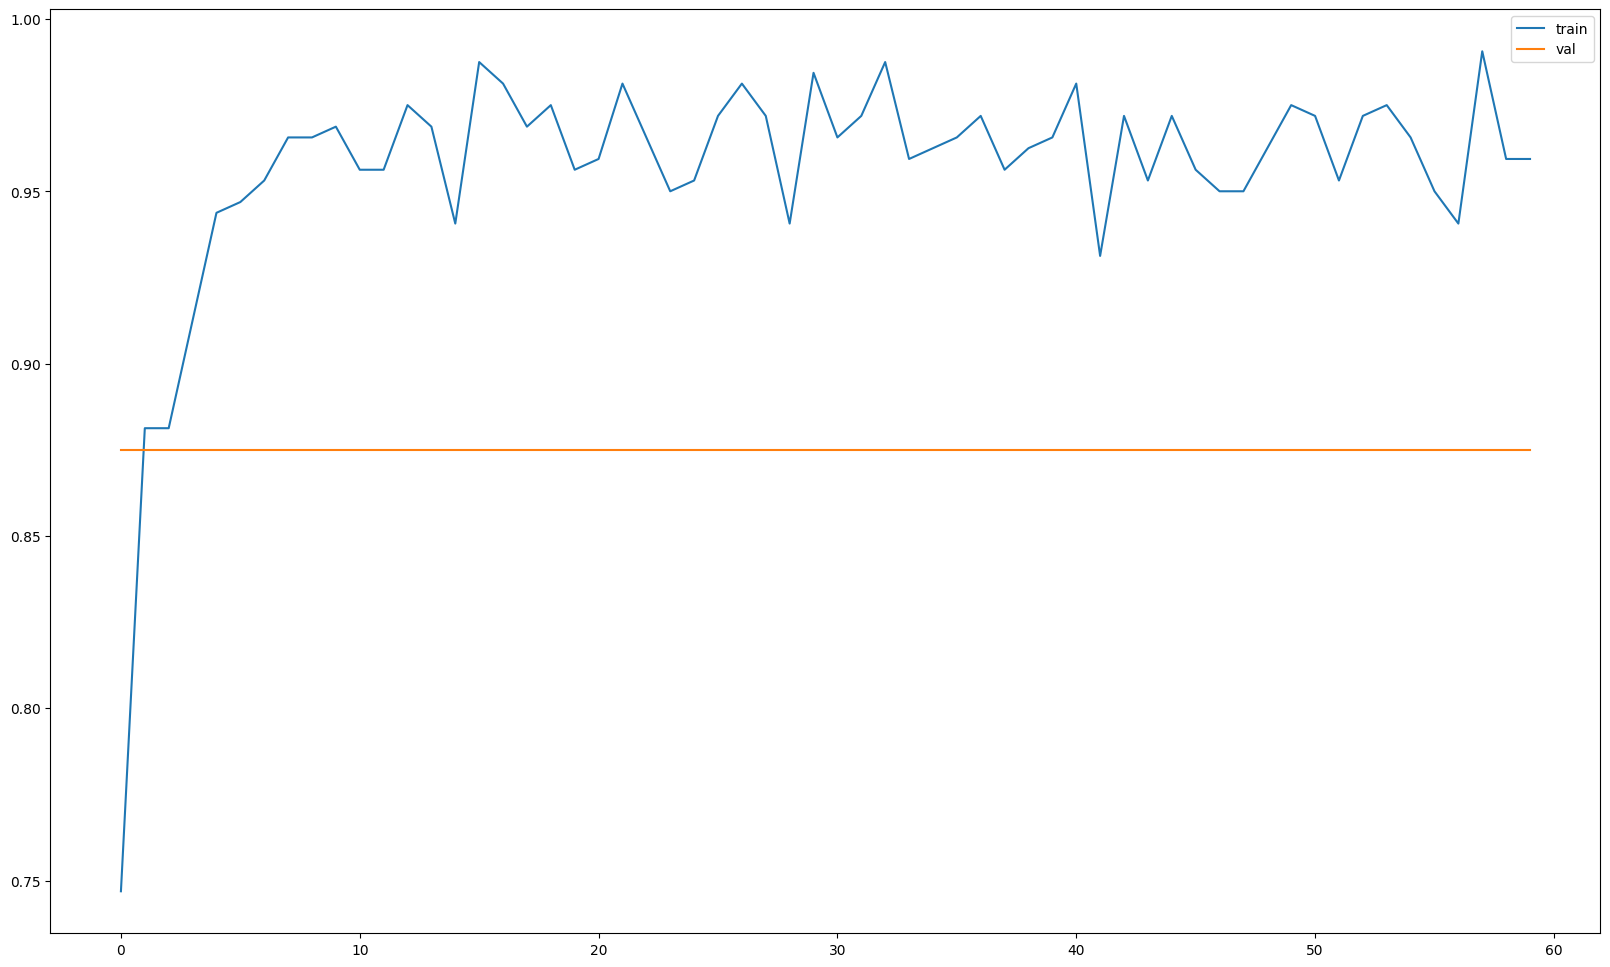

100%|██████████| 60/60 [01:16<00:00,  1.27s/it]


0.9906250238418579
0.625


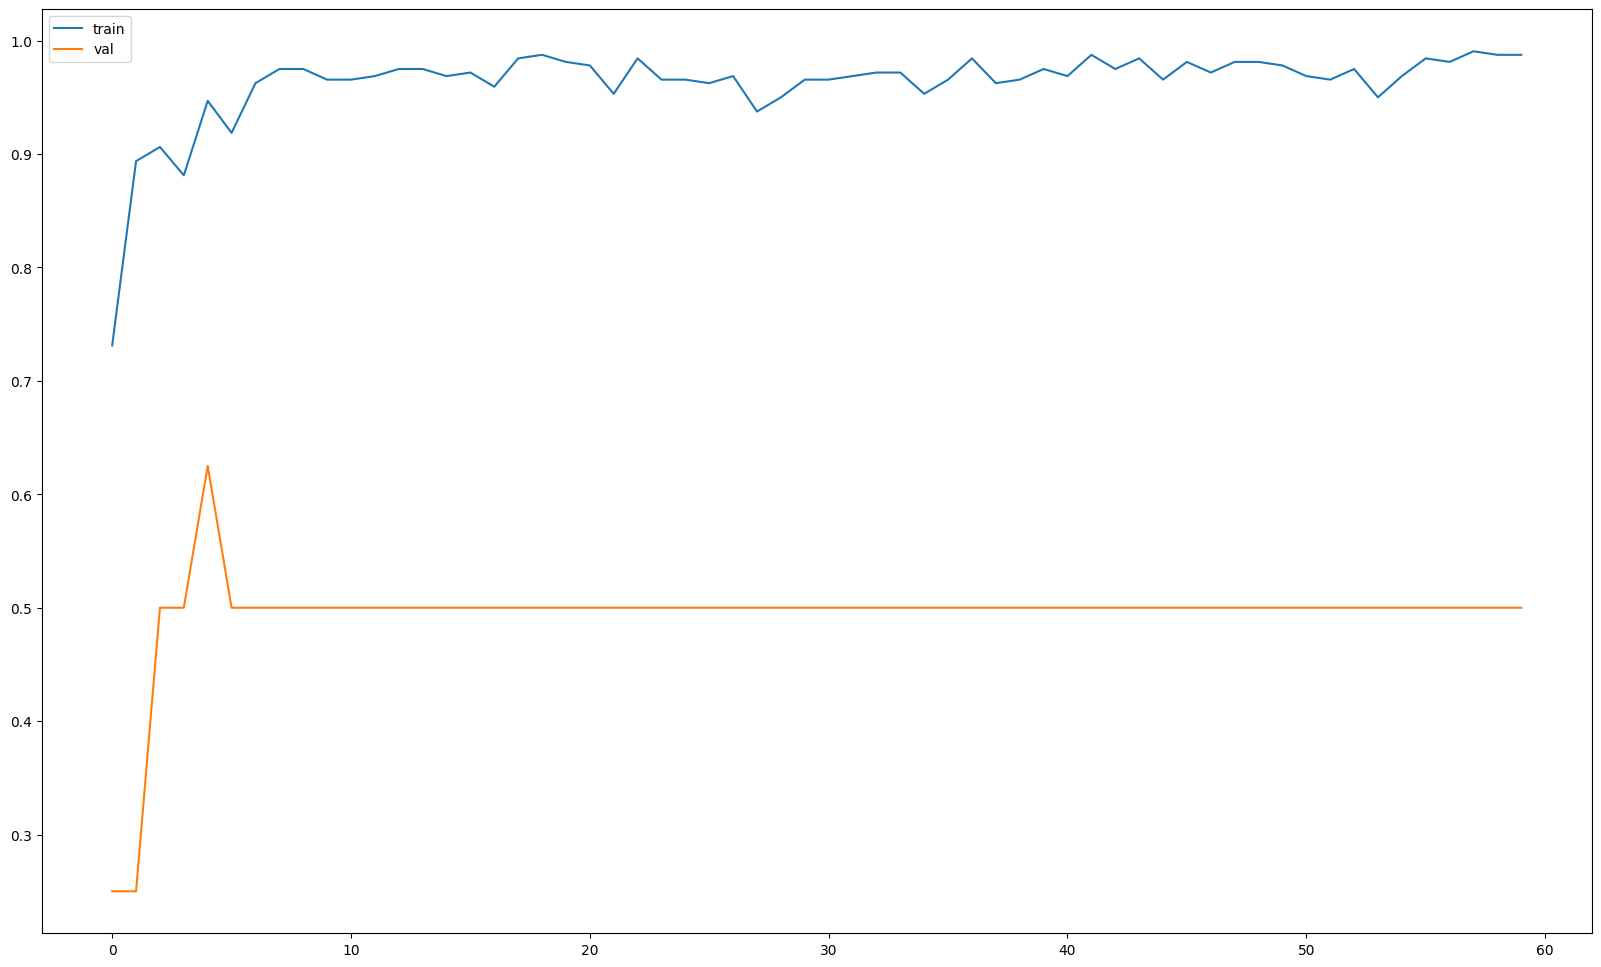

In [8]:
perform_training_instance(0,batch_size,'/kaggle/working/fold 0/train','/kaggle/working/fold 0/val')
perform_training_instance(1,batch_size,'/kaggle/working/fold 1/train','/kaggle/working/fold 1/val')
perform_training_instance(2,batch_size,'/kaggle/working/fold 2/train','/kaggle/working/fold 2/val')
perform_training_instance(3,batch_size,'/kaggle/working/fold 3/train','/kaggle/working/fold 3/val')
perform_training_instance(4,batch_size,'/kaggle/working/fold 4/train','/kaggle/working/fold 4/val')

In [13]:
evaluate_model('/kaggle/working/best_modelx_fold_0.pt', '/kaggle/working/fold 0/val')
evaluate_model('/kaggle/working/best_modelx_fold_1.pt', '/kaggle/working/fold 1/val')
evaluate_model('/kaggle/working/best_modelx_fold_2.pt', '/kaggle/working/fold 2/val')
evaluate_model('/kaggle/working/best_modelx_fold_3.pt', '/kaggle/working/fold 3/val')
evaluate_model('/kaggle/working/best_modelx_fold_4.pt', '/kaggle/working/fold 4/val')

/tmp/ipykernel_37/3025429839.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


tensor(0.9323)
tensor(0.1949)
tensor(0.3407)
tensor(0.3003)
tensor(1.2759)


In [12]:

def evaluate_model(model_path, val_dir):
    val_transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

    val_dataloader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    model = models.resnet18(pretrained=True)
    model.fc = torch.nn.Linear(model.fc.in_features, 2)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()


    val_predictions = []
    val_onehot = []
    val_img_paths = []
    for inputs, labels in val_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        with torch.set_grad_enabled(False):
            preds = model(inputs)
            val_onehot.append(preds.argmax(dim=1))
            m = torch.nn.Softmax(dim=1)
            #preds = m(preds)

        val_predictions.append(m(preds))

    loss_func = torch.nn.CrossEntropyLoss()
    preds = preds.to("cpu")
    tens = torch.Tensor([0,0,0,0,1,1,1,1]).to("cpu").type(torch.LongTensor)

    print(loss_func(preds,tens))

    #print(val_predictions)
    #print(val_onehot)


In [24]:
def evaluate_ensemble():
    list_of_models = []

    model0 = models.resnet18(pretrained=True)
    model0.fc = torch.nn.Linear(model0.fc.in_features, 2)
    model0.load_state_dict(torch.load('/kaggle/working/best_modelx_fold_0.pt'))
    model0.to('cpu')
    model0.eval()

    list_of_models.append(model0)

    model1 = models.resnet18(pretrained=True)
    model1.fc = torch.nn.Linear(model1.fc.in_features, 2)
    model1.load_state_dict(torch.load('/kaggle/working/best_modelx_fold_1.pt'))
    model1.to('cpu')
    model1.eval()

    list_of_models.append(model1)


    model2 = models.resnet18(pretrained=True)
    model2.fc = torch.nn.Linear(model2.fc.in_features, 2)
    model2.load_state_dict(torch.load('/kaggle/working/best_modelx_fold_2.pt'))
    model2.to('cpu')
    model2.eval()

    list_of_models.append(model2)

    model3 = models.resnet18(pretrained=True)
    model3.fc = torch.nn.Linear(model3.fc.in_features, 2)
    model3.load_state_dict(torch.load('/kaggle/working/best_modelx_fold_3.pt'))
    model3.to('cpu')
    model3.eval()

    list_of_models.append(model3)

    model4 = models.resnet18(pretrained=True)
    model4.fc = torch.nn.Linear(model4.fc.in_features, 2)
    model4.load_state_dict(torch.load('/kaggle/working/best_modelx_fold_4.pt'))
    model4.to('cpu')
    model4.eval()
    
    list_of_models.append(model4)

    list_of_valDirs = ['/kaggle/working/fold 0/val',
                      '/kaggle/working/fold 1/val',
                      '/kaggle/working/fold 2/val',
                      '/kaggle/working/fold 3/val',
                      '/kaggle/working/fold 4/val']
    val_onehot = []
    val_predictions = []
    list_of_preds = []
    for index, each_dir in enumerate(list_of_valDirs):
    
        val_transforms = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        val_dataset = torchvision.datasets.ImageFolder(each_dir, val_transforms)

        val_dataloader = torch.utils.data.DataLoader(
            val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
        
        list_of_loss = []
        
        m = torch.nn.Softmax(dim=1)


        for inputs, labels in val_dataloader:
            inputs = inputs.to('cpu')
            labels = labels.to('cpu')
            with torch.set_grad_enabled(False):
                preds = list_of_models[index](inputs)
                val_onehot.append(preds.argmax(dim=1))

                list_of_preds.append(m(preds)) 

            val_predictions.append(m(preds))

            loss_func = torch.nn.CrossEntropyLoss()
            preds = preds.to("cpu")
            tens = torch.Tensor([0,0,0,0,1,1,1,1]).to("cpu").type(torch.LongTensor)
            list_of_loss.append(loss_func(preds,tens))
            #print(loss_func(preds,tens))

    print(list_of_preds)
    print(val_onehot)
    


In [25]:
evaluate_ensemble()

/tmp/ipykernel_37/3943571797.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model0.load_state_dict(torch.load('/kaggle/working/best_modelx_fold_0.pt'))
/tmp/ipykernel_3

[tensor([[0.7495, 0.2505],
        [0.0085, 0.9915],
        [0.5110, 0.4890],
        [0.5628, 0.4372],
        [0.0514, 0.9486],
        [0.4281, 0.5719],
        [0.2004, 0.7996],
        [0.2739, 0.7261]]), tensor([[0.5757, 0.4243],
        [0.8222, 0.1778],
        [0.9242, 0.0758],
        [0.9378, 0.0622],
        [0.0673, 0.9327],
        [0.0014, 0.9986],
        [0.2578, 0.7422],
        [0.2585, 0.7415]]), tensor([[0.8853, 0.1147],
        [0.9530, 0.0470],
        [0.3785, 0.6215],
        [0.6124, 0.3876],
        [0.1494, 0.8506],
        [0.1771, 0.8229],
        [0.0727, 0.9273],
        [0.4837, 0.5163]]), tensor([[0.9478, 0.0522],
        [0.7152, 0.2848],
        [0.8913, 0.1087],
        [0.9395, 0.0605],
        [0.7977, 0.2023],
        [0.0289, 0.9711],
        [0.0103, 0.9897],
        [0.1800, 0.8200]]), tensor([[0.9021, 0.0979],
        [0.5062, 0.4938],
        [0.8870, 0.1130],
        [0.8657, 0.1343],
        [0.9815, 0.0185],
        [0.1440, 0.8560],
   

In [1]:
torch.stack(list_of_loss).mean()

NameError: name 'torch' is not defined

In [29]:
loss_func = torch.nn.CrossEntropyLoss()
preds = preds.to("cpu")
tens = torch.Tensor([0,0,0,0,1,1,1,1]).to("cpu").type(torch.LongTensor)

print(loss_func(preds,tens))

tensor(0.3270)


In [115]:
test_dir = 'test'
#shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
test_dataset = ImageFolderWithPaths('/kaggle/working/test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/kaggle/working/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

submission_df.to_csv("submission_res18_4.csv")

100%|██████████| 93/93 [00:03<00:00, 25.96it/s]


In [ ]:
model.eval()

val_predictions = []
val_img_paths = []
for inputs, labels in tqdm(val_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs).argmax(dim=1)
    val_predictions.append(preds)
        #orch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    #val_img_paths.extend(paths)
    
#val_predictions = np.concatenate(val_predictions)